### EXAMEN DEL MÓDULO 2: 
#### G1: CLASE DE REPASO 11 DE NOVIEMBRE. ENTREGA EL DOMINGO 15 DE NOVIEMBRE. 
#### G2: CLASE DE REPASO 10 DE NOVIEMBRE. ENTREGA EL DOMINGO 14 DE NOVIEMBRE. 


### PROYECTO DE MÓDULO 2 
#### G1: PRESENTACIÓN 23 DE NOVIEMBRE
#### G2: PRESENTACIÓN 20 DE NOVIEMBRE


### REFERENTE AL MÓDULO 3: ECUACIONES DIFERENCIALES. NO HABRÁ EXAMEN, SOLO PROYECTO PARA ENTREGAR EL DÍA:

#### G1: 2 DE DICIEMBRE
#### G2: 1 DE DICIEMBRE

# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [1]:
# Importamos librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web

In [2]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_closes(names, start, end):
    datos = web.DataReader(names,'yahoo',start,end)
    closes = datos['Adj Close']
    return closes   

In [3]:
# Descargamos datos...
# Instrumento: 
names = ['CEMEXCPO.MX','AAPL','FB']

# Fechas de interés (inicio y fin): 2015-2019
start = '2015-01-01'
end = '2019-12-31'

# Función DataReader
precios_NIO = get_closes(names, start, end)

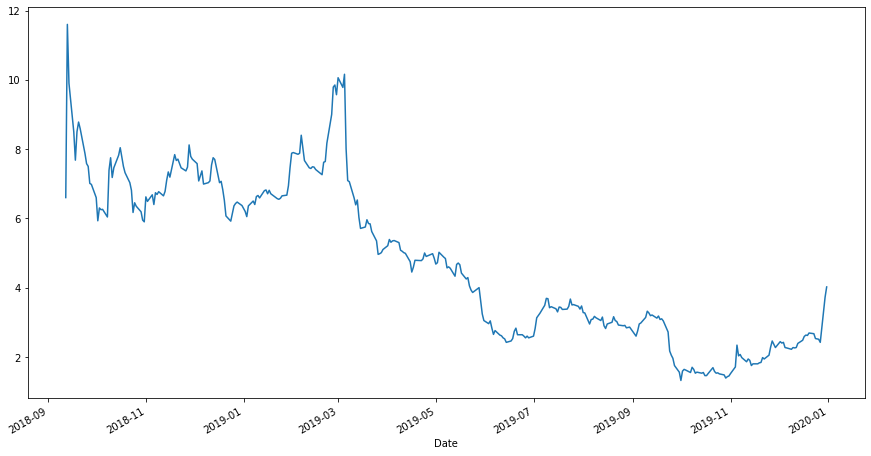

In [4]:
# Graficamos
precios_NIO.plot(figsize=(15,8))

In [5]:
precios_NIO.shift()

Date
2018-09-12      NaN
2018-09-13     6.60
2018-09-14    11.60
2018-09-17     9.90
2018-09-18     8.50
              ...  
2019-12-24     2.67
2019-12-26     2.53
2019-12-27     2.51
2019-12-30     2.42
2019-12-31     3.72
Name: Adj Close, Length: 328, dtype: float64

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

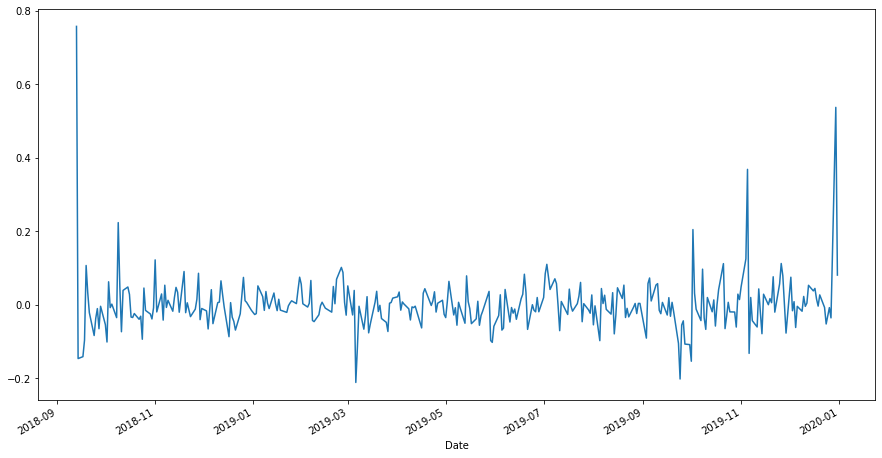

In [6]:
# Calcular rendimientos diarios y graficarlos
ret_NIO = (precios_NIO - precios_NIO.shift())/precios_NIO.shift()
ret_NIO.plot(figsize=(15,8))

Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [7]:
# Calculamos media y desviación estándar
mu = ret_NIO.mean()
sigma = ret_NIO.std()
mu, sigma

(0.0009845917169846305, 0.07651331373467106)

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2019, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2020 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

In [8]:
# Ayuda en la función np.random.randn
help(np.random.randn)

Help on built-in function randn:

randn(...) method of numpy.random.mtrand.RandomState instance
    randn(d0, d1, ..., dn)
    
    Return a sample (or samples) from the "standard normal" distribution.
    
    .. note::
        This is a convenience function for users porting code from Matlab,
        and wraps `standard_normal`. That function takes a
        tuple to specify the size of the output, which is consistent with
        other NumPy functions like `numpy.zeros` and `numpy.ones`.
    
    .. note::
        New code should use the ``standard_normal`` method of a ``default_rng()``
        instance instead; see `random-quick-start`.
    
    If positive int_like arguments are provided, `randn` generates an array
    of shape ``(d0, d1, ..., dn)``, filled
    with random floats sampled from a univariate "normal" (Gaussian)
    distribution of mean 0 and variance 1. A single float randomly sampled
    from the distribution is returned if no argument is provided.
    
    Paramete

In [9]:
# Función que simula varios escenarios de rendimientos diarios
def ret_sim(mu,std,ndays,nscen,start):
    dates = pd.date_range(start=start,periods=ndays)
    simulados = std*np.random.randn(ndays,nscen) + mu
    datos = pd.DataFrame(data=simulados,index=dates)
    return datos

In [10]:
# Simulamos 100 escenarios para todo el 2020
ndays = 365
nscen = 100
start = '2020-01-01'
ret_sim_NIO = ret_sim(mu,sigma,ndays,nscen,start)

In [11]:
# Mostrar
ret_sim_NIO

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2020-01-01,0.065898,0.110085,-0.057502,0.026340,0.007755,0.087987,-0.009491,-0.010940,-0.061202,-0.093377,...,0.026283,0.131707,-0.137412,0.032258,-0.022423,0.079956,0.063081,-0.116615,-0.031812,-0.003118
2020-01-02,0.086708,0.186654,0.097720,0.040814,-0.004456,0.105745,0.220613,0.017709,-0.079950,0.063618,...,-0.054647,-0.002310,-0.049016,0.056004,-0.000557,0.079252,-0.087690,-0.003558,-0.086108,-0.166188
2020-01-03,-0.017570,-0.004714,0.004762,0.226813,0.062640,-0.098609,-0.058084,0.026110,-0.029590,-0.017806,...,0.078875,0.031291,-0.038088,0.010499,-0.097120,0.017551,-0.016013,-0.085035,0.010837,-0.001291
2020-01-04,0.052729,0.093592,-0.028358,-0.102913,0.108923,-0.066747,0.083230,-0.108913,0.019148,0.032749,...,-0.024760,-0.023625,-0.082270,-0.183516,-0.007840,0.003055,0.047621,0.063813,-0.041140,-0.148213
2020-01-05,-0.027685,0.004496,-0.020785,-0.025814,0.027429,-0.056043,-0.027716,0.066423,0.100174,-0.156343,...,0.126394,-0.024137,0.020032,0.032588,-0.078944,-0.149992,-0.038563,-0.100643,-0.029856,-0.079198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,0.028431,0.006592,-0.016664,-0.007258,0.098845,-0.059062,0.042655,-0.047463,0.052857,0.133505,...,0.108280,-0.056773,0.038862,-0.044612,-0.110970,0.032164,0.087830,0.058149,0.097467,-0.029266
2020-12-27,-0.110557,-0.012235,-0.034524,-0.044137,0.015505,-0.057901,0.119489,-0.061956,-0.014230,-0.014533,...,-0.027747,-0.073917,-0.072987,-0.056499,-0.050299,-0.016657,0.046081,-0.100866,0.068519,0.031324
2020-12-28,-0.061543,-0.044171,-0.069366,0.072539,0.050092,0.152963,0.145951,0.070889,0.009398,0.052022,...,0.025682,0.011541,0.069954,0.047148,0.034683,0.079988,0.046632,-0.054745,0.012158,-0.117194
2020-12-29,0.127336,0.016501,-0.059412,-0.090356,-0.039909,-0.029665,0.034957,0.160847,-0.071397,0.029767,...,0.186562,0.182057,-0.068585,0.070598,0.063003,-0.057641,-0.058878,-0.067135,-0.080360,0.034025


## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado en el 2019.

Con los rendimientos, calculamos los precios de cierre...

In [12]:
# Obtenemos los precios. Transformar los rendimientos simulados del 2020 a precios de acción simulados del 2019.
precios_sim_NIO = precios_NIO.iloc[-1]*((1+ret_sim_NIO).cumprod())
precios_sim_NIO

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2020-01-01,4.284911,4.462543,3.788844,4.125887,4.051174,4.373709,3.981845,3.976021,3.773967,3.644623,...,4.125659,4.549464,3.467602,4.149676,3.929858,4.341423,4.273584,3.551209,3.892116,4.007465
2020-01-02,4.656445,5.295494,4.159088,4.294281,4.033121,4.836205,4.860293,4.046433,3.472240,3.876486,...,3.900203,4.538953,3.297635,4.382075,3.927668,4.685491,3.898832,3.538573,3.556973,3.341470
2020-01-03,4.574631,5.270530,4.178894,5.268278,4.285757,4.359310,4.577989,4.152085,3.369495,3.807461,...,4.207832,4.680981,3.172035,4.428081,3.546213,4.767728,3.836398,3.237672,3.595520,3.337156
2020-01-04,4.815848,5.763810,4.060388,4.726105,4.752577,4.068338,4.959016,3.699870,3.434015,3.932151,...,4.103648,4.570394,2.911072,3.615458,3.518412,4.782293,4.019092,3.444278,3.447602,2.842546
2020-01-05,4.682522,5.789726,3.975995,4.604104,4.882935,3.840335,4.821572,3.945625,3.778016,3.317388,...,4.622326,4.460077,2.969388,3.733278,3.240656,4.064988,3.864103,3.097634,3.344670,2.617422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,0.301354,1.211945,2.887281,1.485570,19.697063,2.053687,0.318555,1.080886,9.137422,0.699969,...,0.659196,0.494499,5.330529,1.669839,1.791930,1.688972,3.183413,3.175570,0.231939,0.135195
2020-12-27,0.268037,1.197117,2.787599,1.420002,20.002472,1.934776,0.356619,1.013919,9.007399,0.689796,...,0.640905,0.457947,4.941468,1.575496,1.701797,1.660838,3.330107,2.855263,0.247831,0.139430
2020-12-28,0.251541,1.144239,2.594234,1.523008,21.004440,2.230725,0.408668,1.085795,9.092048,0.725681,...,0.657365,0.463233,5.287143,1.649777,1.760821,1.793686,3.485396,2.698953,0.250844,0.123089
2020-12-29,0.283571,1.163120,2.440106,1.385395,20.166175,2.164551,0.422954,1.260442,8.442904,0.747283,...,0.780004,0.547567,4.924525,1.766248,1.871757,1.690295,3.280185,2.517759,0.230686,0.127277


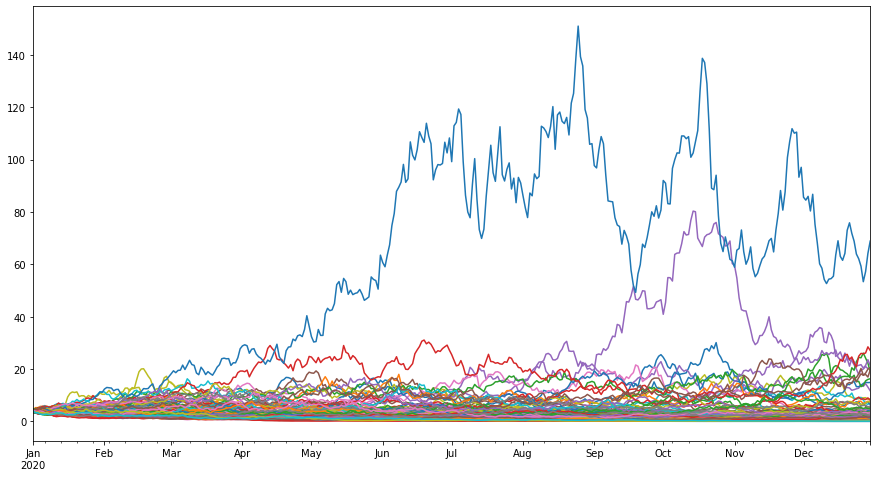

In [13]:
# Graficar
precios_sim_NIO.plot(figsize=(15,8),legend=False)

In [14]:
K = precios_NIO.iloc[-1]*1.2
K

4.823999977111816

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [15]:
# Umbral de 120% del ultimo precio
K = precios_NIO.iloc[-1]*1.2

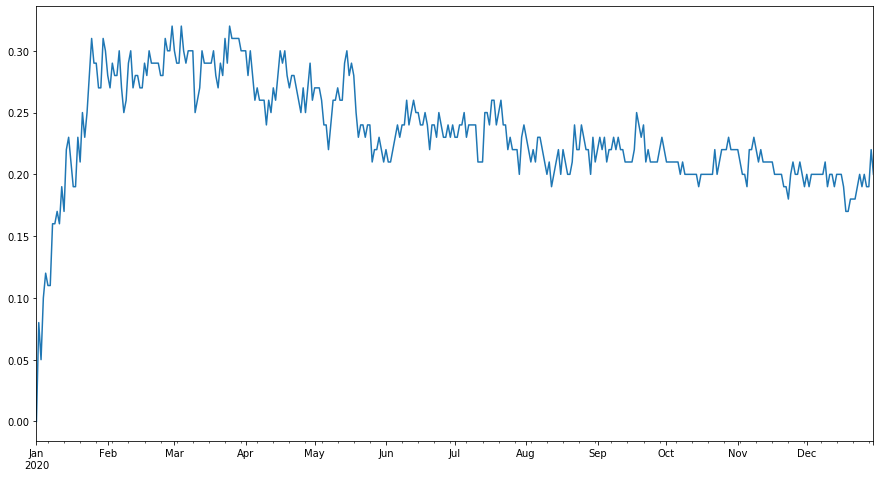

In [16]:
# Comparar cada escenario en cada fecha
TF = precios_sim_NIO > K

# Sumamos para cada fecha y dividimos entre el número de escenarios
prob = TF.sum(axis=1)/nscen

# Gráfico de probabilidad
prob.plot(figsize=(15,8),legend=False)

In [18]:
# Descargamos datos...
# Instrumento: 
name = 'NIO'

# Fechas de interés (inicio y fin): 2015-2019
start='2020-01-01'
end = '2020-11-10'

# Función DataReader
precios_reales = get_closes(name,start,end)

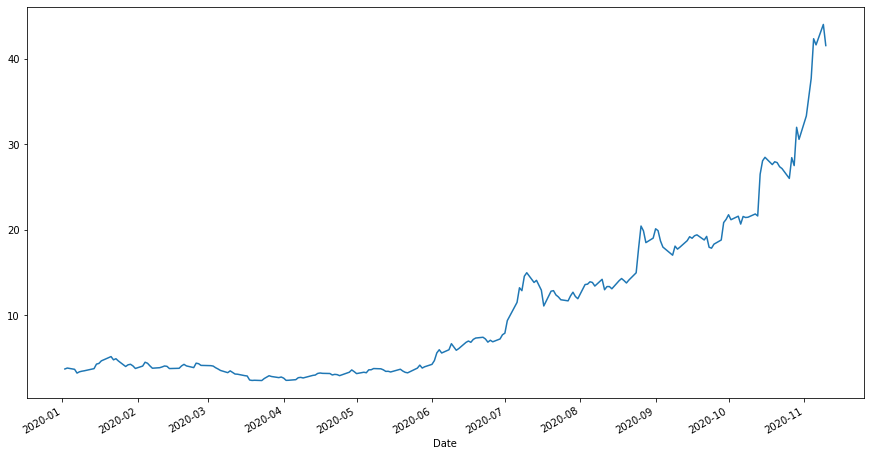

In [19]:
precios_reales.plot(figsize=(15,8))

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Cristian Camilo Zapata Zuluaga.
</footer>